In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


import sys
sys.path.append('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/')

In [2]:
from functions import (calculate_gaussian_center, extract_signal_window_by_fraction, 
                       plot_gaussian, get_gaussian_params)
from Models import ConvolutionalModel

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'
test_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_test.npz'))['data']
test_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_test.npz'))['data']
test_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_test.npz'))['data']

test_data  = np.concatenate((test_data_55, test_data_28, test_data_82), axis = 0)
print('Número de casos de test: ', test_data.shape[0])

Número de casos de test:  21993


In [4]:
# -------------------------------------------------------------------------
#----------------------- IMPORTANT DEFINITIONS ----------------------------
# -------------------------------------------------------------------------
time_step = 0.2         # Signal time step in ns
nbins = 71              # Num bins for all histograms                   
t_shift = 1             # Time steps to move for the new positions
start = 47 
stop = 74 
Num_train = 3000
Num_test = test_data.shape[0] - Num_train

# **NN MODEL PREDICTIONS**

In [5]:
# -------------------------------------------------------------------------
#--------------------------- LOAD MODELS ----------------------------------
# -------------------------------------------------------------------------

dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions/Convolutional/'

model_dec0_dir = os.path.join(dir, 'Conv_model_dec0')
model_dec1_dir = os.path.join(dir, 'Conv_model_dec1')

model_dec0 = ConvolutionalModel(int(stop-start))
model_dec1 = ConvolutionalModel(int(stop-start))

model_dec0.load_state_dict(torch.load(model_dec0_dir))
model_dec1.load_state_dict(torch.load(model_dec1_dir))
model_dec0.eval()
model_dec1.eval()

# -------------------------------------------------------------------------
#--------------------------- GET RESULTS ----------------------------------
# -------------------------------------------------------------------------
TEST = test_data[:,start:stop,:] 
test_dec0 = np.squeeze(model_dec0(torch.tensor(TEST[:,None,:,0]).float()).detach().numpy())
test_dec1 = np.squeeze(model_dec1(torch.tensor(TEST[:,None,:,1]).float()).detach().numpy())


# Calculate TOF
TOF = test_dec0 - test_dec1

TOF_V00 = TOF[:test_data_55.shape[0]] 
TOF_V02 = TOF[ test_data_55.shape[0] : test_data_55.shape[0] + test_data_28.shape[0]] 
TOF_V20 = TOF[ test_data_55.shape[0]  + test_data_28.shape[0]:] 
    

In [6]:
# Calulate Validation error
centroid_V00 = calculate_gaussian_center(TOF_V00[np.newaxis,:], nbins = nbins, limits = 3) 
 
error_V02 = (TOF_V02 - centroid_V00 + t_shift*time_step)
error_V00 = (TOF_V00 - centroid_V00)
error_V20 = (TOF_V20 - centroid_V00 - t_shift*time_step)


# Train/test target split
Error_train = np.concatenate((error_V02[:Num_train], error_V20[:Num_train], error_V00[:Num_train]))
Error_test = np.concatenate((error_V02[Num_train:], error_V20[Num_train:], error_V00[Num_train:]))

# **PYCARET CORRECTION**

In [7]:
# Eliminate time dependencies by getting signals by a fixed fraction
new_data_28 = extract_signal_window_by_fraction(test_data_28, fraction = 0.1, window_low = 10, window_high = 7)
new_data_55 = extract_signal_window_by_fraction(test_data_55, fraction = 0.1, window_low = 10, window_high = 7)
new_data_82 = extract_signal_window_by_fraction(test_data_82, fraction = 0.1, window_low = 10, window_high = 7)

TRAIN = np.concatenate((new_data_28[:Num_train], new_data_55[:Num_train], new_data_82[:Num_train]), axis = 0)
TEST  = np.concatenate((new_data_28[Num_train:], new_data_55[Num_train:], new_data_82[Num_train:]), axis = 0)

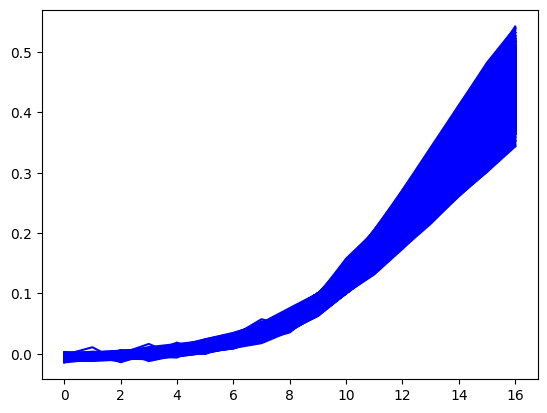

In [8]:
for i in range(new_data_28.shape[0]):
    plt.plot(new_data_28[i,:,0], 'b-')

In [9]:
# Get train/test time independent parameters
mean_train = np.mean(TRAIN, axis = 1)
variance_train = np.var(TRAIN, axis = 1)
skewness_train = skew(TRAIN, axis = 1)
kurtosis_train = kurtosis(TRAIN, axis = 1)

mean_test = np.mean(TEST, axis = 1)
variance_test = np.var(TEST, axis = 1)
skewness_test = skew(TEST, axis = 1)
kurtosis_test = kurtosis(TEST, axis = 1)


# Concatenate the train/test features
features_train = np.stack((mean_train[:,0], variance_train[:,0], skewness_train[:,0], kurtosis_train[:,0], 
                           mean_train[:,1], variance_train[:,1], skewness_train[:,1], kurtosis_train[:,1]), axis = 1)

features_test = np.stack((mean_test[:,0], variance_test[:,0], skewness_test[:,0], kurtosis_test[:,0], 
                          mean_test[:,1], variance_test[:,1], skewness_test[:,1], kurtosis_test[:,1]), axis = 1)

In [10]:
# Save to a DataFrame 
features_train_df = pd.DataFrame(features_train, columns = ['Mean_dec0', 'Variance_dec0', 'Skewness_dec0', 'Kurtosis_dec0',
                                                            'Mean_dec1', 'Variance_dec1', 'Skewness_dec1', 'Kurtosis_dec1'])

features_test_df = pd.DataFrame(features_test, columns = ['Mean_dec0', 'Variance_dec0', 'Skewness_dec0', 'Kurtosis_dec0',
                                                          'Mean_dec1', 'Variance_dec1', 'Skewness_dec1', 'Kurtosis_dec1'])

In [11]:
from pycaret.regression import *
s = setup(features_train_df, target = Error_train,  session_id = 123, normalize = True, normalize_method = 'zscore')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(9000, 9)"
4,Transformed data shape,"(9000, 9)"
5,Transformed train set shape,"(6300, 9)"
6,Transformed test set shape,"(2700, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [12]:
model = compare_models(['rf', 'lr', 'dt','et'])
print(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0803,0.0113,0.1059,-0.0028,0.0926,1.1462,0.0750
rf,Random Forest Regressor,0.0827,0.0120,0.1090,-0.0645,0.0833,2.1353,0.2930
et,Extra Trees Regressor,0.0838,0.0122,0.1097,-0.0789,0.0817,1.9873,0.0800
dt,Decision Tree Regressor,0.1167,0.0250,0.1575,-1.2963,0.0877,6.4007,0.0810


LinearRegression(n_jobs=-1)


In [13]:
# Get more detailed model evaluations
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

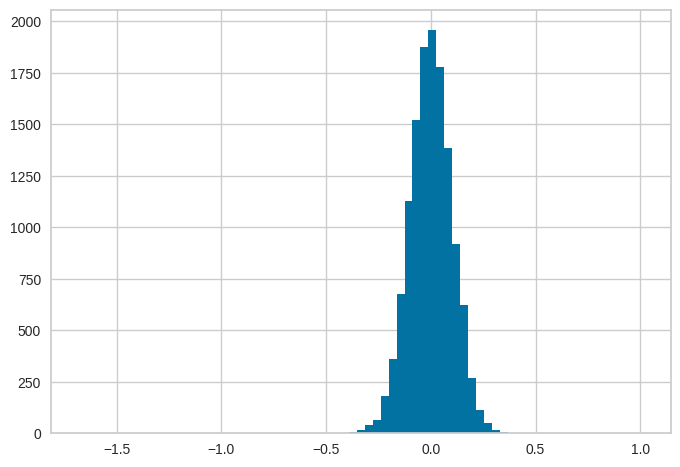

In [14]:
predictions_ML = predict_model(model, data = features_test_df)

Error_pred = predictions_ML['prediction_label'].to_numpy() - Error_test
plt.hist(Error_pred, bins = nbins);

In [15]:
# Get test set predictions
predictions = predictions_ML['prediction_label'].to_numpy()

predictions_V02 = predictions[new_data_28[Num_train:].shape[0]] 
predictions_V00 = predictions[new_data_28[Num_train:].shape[0] : new_data_28[Num_train:].shape[0] + new_data_55[Num_train:].shape[0]]
predictions_V20 = predictions[new_data_28[Num_train:].shape[0] + new_data_55[Num_train:].shape[0] :]

# Correct test set TOF
TOF_V02_corr = TOF_V02[Num_train:]  - predictions_V02
TOF_V00_corr = TOF_V00[Num_train:]  - predictions_V00
TOF_V20_corr = TOF_V20[Num_train:]  - predictions_V20


V20: CENTROID(ns) = 0.1877 +/- 0.00092  FWHM(ns) = 0.2307 +/- 0.00099
V00: CENTROID(ns) = -0.0002 +/- 0.00074  FWHM(ns) = 0.2352 +/- 0.00080
V02: CENTROID(ns) = -0.1872 +/- 0.00131  FWHM(ns) = 0.2338 +/- 0.00141



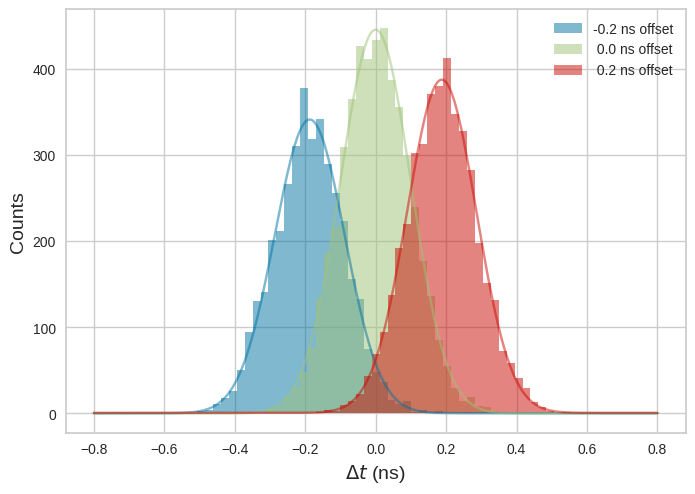

In [16]:
centroid_V00 = calculate_gaussian_center(TOF_V00_corr[None, :], nbins = nbins, limits = 3) 


# Histogram and gaussian fit
plot_gaussian(TOF_V02_corr, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00_corr, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20_corr, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_V02_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20_corr, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()


# **NN Approach**

In [17]:
import numpy as np
import torch
import torch.optim as optim
from functions import set_seed
from Models import MLP_Torch

set_seed(42)

In [18]:
Error_train = Error_train.astype(np.float32)
Error_test = Error_test.astype(np.float32)

In [19]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(features_train).float(), torch.from_numpy(np.expand_dims(Error_train, axis = -1)).float())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(features_test).float(), torch.from_numpy(np.expand_dims(Error_test, axis = -1)).float())


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [20]:
def train_loop_MLP(model, optimizer,  train_loader, val_loader, test_tensor, EPOCHS = 75, name = 'model', save = False):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    test_tensor = test_tensor.to(device)
    
    
    loss_list = []
    val_loss_list = []
    test = []

    # Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

    for epoch in range(EPOCHS):
        running_loss = 0.0
        avg_loss_epoch = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero your gradients for every batch
            optimizer.zero_grad()

            # Make predictions for this batch for both channels
            outputs= model(inputs)

            # Compute the loss and its gradients
            loss = torch.mean((outputs - labels)**2)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            # Accumulate running loss
            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Calculate average loss per epoch
        avg_loss_epoch = running_loss / int(i)  # loss per batch
        loss_list.append(avg_loss_epoch)

        print('EPOCH {}:'.format(epoch + 1))
        print('LOSS train {}'.format(avg_loss_epoch))

        # Calculate predictions on test_tensor
        model.eval()
        with torch.no_grad():
            test_epoch = model(test_tensor)
            test.append(np.squeeze(test_epoch.cpu().numpy()))

            val_loss = 0
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val = model(val_data)
                val_loss += torch.mean(abs(val - val_labels))
            val_loss_list.append(val_loss.cpu().numpy() / len(val_loader))
            print(f'LOSS val {val_loss / len(val_loader)}')


    # Save the model at the specified checkpoint frequency if 'save' is True
    if save:
       torch.save(model.state_dict(), name)

    

    return np.array(loss_list, dtype = 'object'), np.array(val_loss_list, dtype = 'object'), np.array(test, dtype = 'object')


In [21]:
epochs = 500
model = MLP_Torch(NM = 8, NN = 32, STD_INIT = 0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4)  

loss, val_loss, test = train_loop_MLP(model, optimizer, train_loader, val_loader, torch.tensor(features_test).float(), EPOCHS = epochs) 

EPOCH 1:
LOSS train 12.81443677588409
LOSS val 0.14497189223766327
EPOCH 2:
LOSS train 0.02985804605884378
LOSS val 0.11905857920646667
EPOCH 3:
LOSS train 0.022445441465625982
LOSS val 0.10829512029886246
EPOCH 4:
LOSS train 0.019556877335858303
LOSS val 0.10500369966030121
EPOCH 5:
LOSS train 0.017956177654321507
LOSS val 0.09980927407741547
EPOCH 6:
LOSS train 0.016572848517527255
LOSS val 0.09830047935247421
EPOCH 7:
LOSS train 0.01584755009192695
LOSS val 0.09477776288986206
EPOCH 8:
LOSS train 0.015263801477054048
LOSS val 0.09381631016731262
EPOCH 9:
LOSS train 0.014736483556307932
LOSS val 0.09883809089660645
EPOCH 10:
LOSS train 0.014151876172534723
LOSS val 0.08988062292337418
EPOCH 11:
LOSS train 0.013761967178632992
LOSS val 0.09058929979801178
EPOCH 12:
LOSS train 0.013777654440708963
LOSS val 0.09134124964475632
EPOCH 13:
LOSS train 0.013414154712481962
LOSS val 0.08693189918994904
EPOCH 14:
LOSS train 0.01286477487686743
LOSS val 0.09345672279596329
EPOCH 15:
LOSS train 

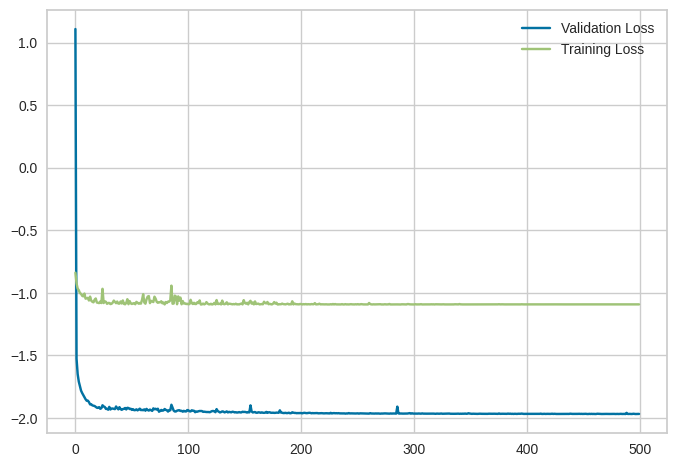

In [22]:
plt.plot(np.log10(loss.astype(np.float64)), label = 'Validation Loss')
plt.plot(np.log10(val_loss.astype(np.float64)), label = 'Training Loss')
plt.legend()

In [23]:
# Get test set predictions
predictions = test[-1, :]

predictions_V02 = predictions[new_data_28[Num_train:].shape[0]] 
predictions_V00 = predictions[new_data_28[Num_train:].shape[0] : new_data_28[Num_train:].shape[0] + new_data_55[Num_train:].shape[0]]
predictions_V20 = predictions[new_data_28[Num_train:].shape[0] + new_data_55[Num_train:].shape[0] :]

# Correct test set TOF
TOF_V02_corr = TOF_V02[Num_train:]  - predictions_V02
TOF_V00_corr = TOF_V00[Num_train:]  - predictions_V00
TOF_V20_corr = TOF_V20[Num_train:]  - predictions_V20


V20: CENTROID(ns) = 0.1869 +/- 0.00076  FWHM(ns) = 0.2316 +/- 0.00082
V00: CENTROID(ns) = -0.0005 +/- 0.00072  FWHM(ns) = 0.2369 +/- 0.00078
V02: CENTROID(ns) = -0.1875 +/- 0.00127  FWHM(ns) = 0.2339 +/- 0.00137



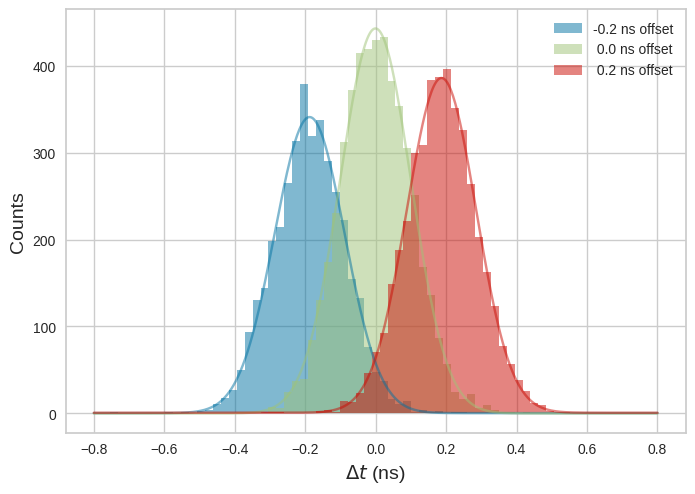

In [24]:
centroid_V00 = calculate_gaussian_center(TOF_V00_corr[None, :], nbins = nbins, limits = 3) 


# Histogram and gaussian fit
plot_gaussian(TOF_V02_corr, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00_corr, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20_corr, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_V02_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20_corr, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()


(12993,)


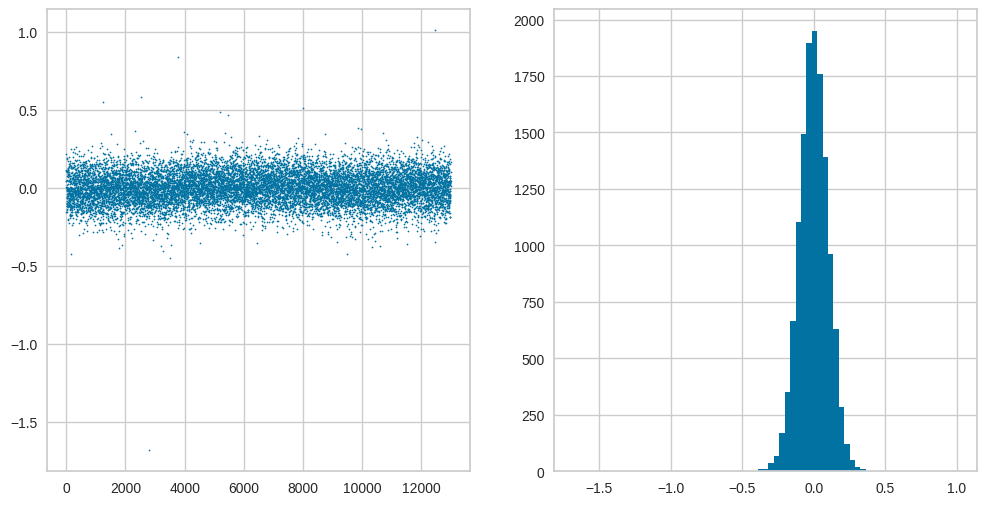

In [25]:
# Caculate residuals
residuals = predictions - Error_test
a = np.where(residuals < 2)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(residuals[a], 'b.', markersize = 2.5)
plt.subplot(122)
plt.hist(residuals[a], bins = nbins)
print(residuals.shape)